In [1]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

In [2]:
from qiskit.circuit.library.standard_gates import XGate, HGate

In [3]:
from operator import *

In [4]:
# Number of Qubits
n = 3
N = (2)**n

print("Maximum number of entires =", N)

Maximum number of entires = 8


Database Encoding


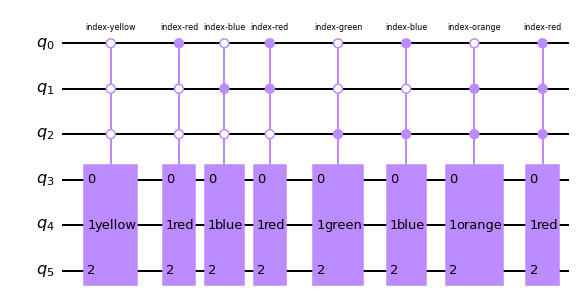

In [5]:
# Creating a database

index_colour_table = {}

colour_hash_map = {}

if n==2:
    index_colour_table = {'00':"red", '01':"orange", '10':"blue", '11':"green"}

    colour_hash_map = {"red":'11', "orange":'10', "blue":'00', "green":'01'}
    
elif n==3:
    index_colour_table = {'000':"yellow", '001':"red", '010':"blue", '011':"red", '100':"green", '101':"blue", '110':"orange", '111':"red"}

    colour_hash_map = {"yellow":'100', "red":'011', "blue":'000', "green":'001', "orange":'010'}


# Creating a Quantum Database Circuit

def database_oracle(index_colour_table, colour_hash_map):

    circ_database = QuantumCircuit(n + n)

    for i in range(N):
    
        circ_data = QuantumCircuit(n)
    
        idx = bin(i)[2:].zfill(n) # removing the "0b" prefix appended by the bin() funtion

    
        colour = index_colour_table[idx]
    
        colour_hash = colour_hash_map[colour][::-1]
    
        for j in range(n):
            if colour_hash[j] == '1':
                circ_data.x(j)
    
        # qiskit maps the rightmost bit as the 0th qubit -> qn, ..., q0
        # we therefore reverse the index string -> q0, ..., qn
    
        data_gate = circ_data.to_gate(label=colour).control(num_ctrl_qubits=n, ctrl_state=idx, label="index-"+colour)
    
        circ_database.append(data_gate, list(range(n+n)))
        
    return circ_database

# drawing the database oracle circuit

print("Database Encoding")
database_oracle(index_colour_table, colour_hash_map).draw()    

Internal colour encoding for the colour green (as an example)


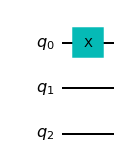

In [6]:
# Showing the internal colour encoding for the colour green (as an example)

circ_data = QuantumCircuit(n)

m = 0
if n==2:
    m=3
elif n==3:
    m=4

idx = bin(m)[2:].zfill(n) # removing the "0b" prefix appended by the bin() funtion
    
colour = index_colour_table[idx]
    
colour_hash = colour_hash_map[colour][::-1]
    
for j in range(n):
    if colour_hash[j] == '1':
        circ_data.x(j)

print("Internal colour encoding for the colour green (as an example)");
        
circ_data.draw()

Grover Oracle (target example: orange)


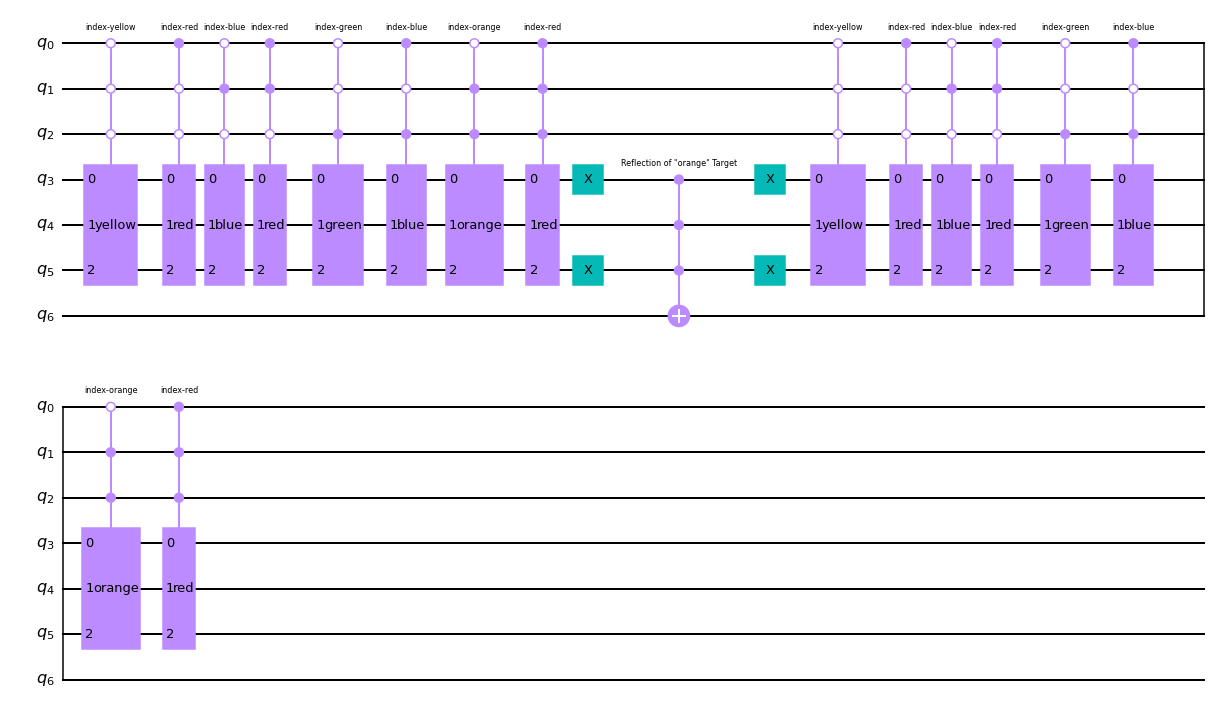

In [7]:
# Defining the Grover Oracle

def oracle_grover(database, data_entry):
    
    circ_grover = QuantumCircuit(n + n + 1)
    
    circ_grover.append(database, list(range(n+n)))
    

    target_reflection_gate = XGate().control(num_ctrl_qubits=n, ctrl_state=colour_hash_map[data_entry], label="Reflection of " + "\"" + data_entry + "\" Target")
    
    
    # control() missing 1 required positional argument: 'self' .... if only 'XGate' used instead of 'XGate()'
    # The “missing 1 required positional argument: 'self'” error is raised when you do not instantiate an object of a class before calling a class method. This error is also raised when you incorrectly instantiate a class.
    
    circ_grover.append(target_reflection_gate, list(range(n, n+n+1)))
    
    circ_grover.append(database, list(range(n+n)))
    
    return circ_grover

print("Grover Oracle (target example: orange)")
oracle_grover(database_oracle(index_colour_table, colour_hash_map).to_gate(label="Database Encoding"), "orange").decompose().draw()  


Multi-controlled Z (MCZ) Gate


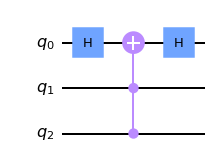

In [8]:
# Defining the Multi-controlled Z (MCZ) Gate

def mcz_gate(num_qubits):
    
    num_controls = num_qubits - 1
    
    mcz_gate = QuantumCircuit(num_qubits)
    
    target_mcz = QuantumCircuit(1)
    
    target_mcz.z(0)
    
    target_mcz = target_mcz.to_gate(label="Z_Gate").control(num_ctrl_qubits=num_controls, ctrl_state=None, label="MCZ")
    
    mcz_gate.append(target_mcz, list(range(num_qubits)))
    
    return mcz_gate.reverse_bits()

print("Multi-controlled Z (MCZ) Gate")

mcz_gate(n).decompose().draw()

Diffusion Circuit


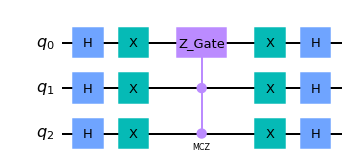

In [9]:
# Defining the Diffusion Operator

def diffusion_operator(num_qubits):
    
    circ_diffusion = QuantumCircuit(num_qubits)
    
    qubits_list = list(range(num_qubits))
    
    # Layer of H^n gates
    circ_diffusion.h(qubits_list)
    
    # Layer of X^n gates
    circ_diffusion.x(qubits_list)
        
    # Layer of Multi-controlled Z (MCZ) Gate
    circ_diffusion = circ_diffusion.compose(mcz_gate(num_qubits), qubits_list)
    
    # Layer of X^n gates
    circ_diffusion.x(qubits_list)
        
    # Layer of H^n gates
    circ_diffusion.h(qubits_list)
    
    return circ_diffusion

print("Diffusion Circuit")

diffusion_operator(n).draw()

Searching for the index of the colour green


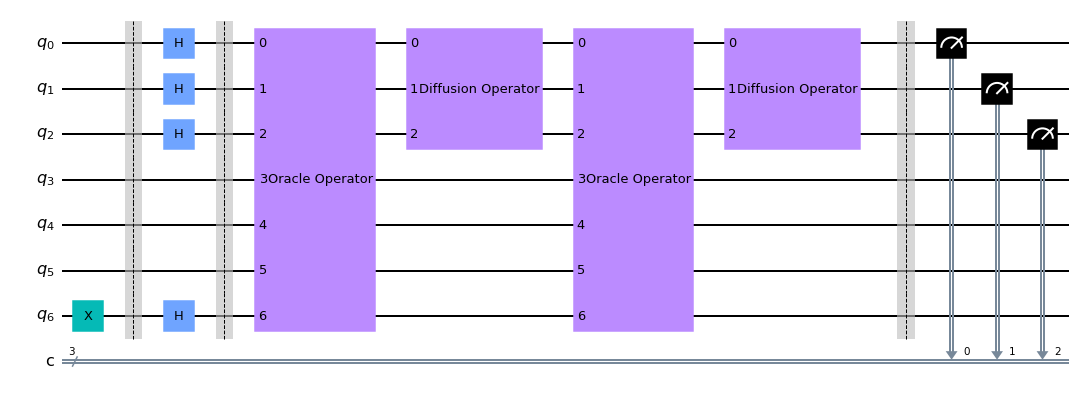

In [10]:
# Putting it all together ... !!!

item = "green"

print("Searching for the index of the colour", item)

circuit = QuantumCircuit(n + n + 1, n)

circuit.x(n + n)
circuit.barrier()

circuit.h(list(range(n)))
circuit.h(n+n)
circuit.barrier()


unitary_oracle = oracle_grover(database_oracle(index_colour_table, colour_hash_map).to_gate(label="Database Encoding"), item).to_gate(label="Oracle Operator")

unitary_diffuser = diffusion_operator(n).to_gate(label="Diffusion Operator")

M = countOf(index_colour_table.values(), item)

Q = int(np.pi * np.sqrt(N/M) / 4)

for i in range(Q):

    circuit.append(unitary_oracle, list(range(n + n + 1)))

    circuit.append(unitary_diffuser, list(range(n)))


circuit.barrier()


circuit.measure(list(range(n)), list(range(n)))

circuit.draw()


Index of the colour green is the most probable outcome


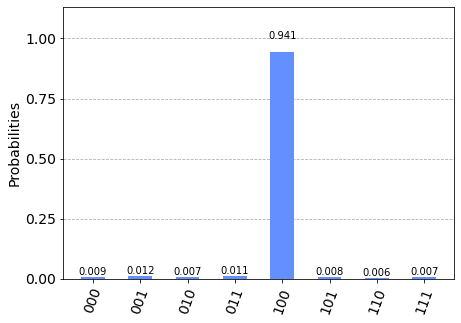

In [11]:
backend_sim = Aer.get_backend('qasm_simulator')

job_sim = backend_sim.run(transpile(circuit, backend_sim), shots=1024)


result_sim = job_sim.result()

counts = result_sim.get_counts(circuit)

if M==1:
    print("Index of the colour", item, "is the most probable outcome")
else:
    print("Indices of the colour", item, "are the most probable outcomes")

from qiskit.visualization import plot_histogram
plot_histogram(counts)